In [2]:
from thejoker.data import RVData
# from thejoker.sampler import JokerParams, TheJoker
from thejoker.plot import plot_rv_curves
import astropy.units as u
import schwimmbad
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u

t, rv, err = np.loadtxt('data/RV/bischoff_rv_fixed_time.txt',usecols=(0,1,2)).T
# t, rv, err = np.loadtxt('data/kic10080943a_JDrv.txt', delimiter=',', usecols=(0,1,2)).T
# t -= t[0]
rv *= u.km/u.s
err *= u.km/u.s 

In [11]:
data = RVData(t=t, rv=rv, stddev=err)
params = JokerParams(P_min=8*u.day, P_max=100*u.day)
pool = schwimmbad.MultiPool()
joker = TheJoker(params, pool=pool)

samples = joker.rejection_sample(data, n_prior_samples=65536)

fig, ax = plt.subplots(1, 1, figsize=(6,6)) # doctest: +SKIP
ax.scatter(samples['P'].value, samples['K'].to(u.km/u.s).value,
           marker='.', color='k', alpha=0.45) # doctest: +SKIP
ax.set_xlabel("$P$ [day]")
ax.set_ylabel("$K$ [km/s]")

TypeError: missing a required argument: 'rv_err'

In [3]:
samples

JokerSamples([('P', <Quantity [51.78419567] d>),
              ('M0', <Quantity [3.41342529] rad>),
              ('e', <Quantity [0.37726773]>),
              ('omega', <Quantity [0.72897589] rad>),
              ('jitter', <Quantity [0.] km / s>),
              ('K', <Quantity [45.52419893] km / s>),
              ('v0', <Quantity [-14.38947579] km / s>)])

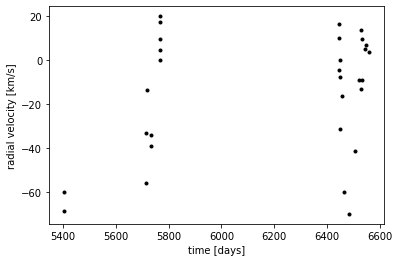

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

x = t
y = rv#.value
# y -= np.mean(y)
yerr = err#.value

plt.errorbar(x, y, yerr=yerr, fmt=".k")
plt.xlabel("time [days]")
plt.ylabel("radial velocity [km/s]");

<ErrorbarContainer object of 3 artists>

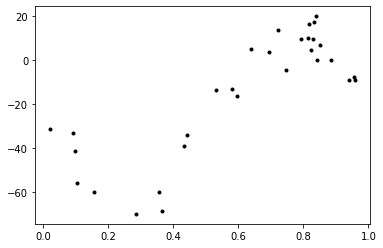

In [18]:
plt.errorbar(x % 14.1742 / 14.1742, y, yerr=yerr, fmt=".k")

In [4]:

import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u

t, rv = np.loadtxt('../soda_rv2.txt',usecols=(0,1)).T
# t, rv, err = np.loadtxt('data/kic10080943a_JDrv.txt', delimiter=',', usecols=(0,1,2)).T
# t -= t[0]
err = np.ones_like(rv)

x, y = t, rv

In [5]:
import exoplanet as xo

period = 51.4167
period_err = [0.1]
t0s = 5974.76 + 51.4167/2#[0]
t0_errs = [0.0007]
Ks = 38.9#samples['K'].value
yerr = np.ones_like(x)

In [6]:
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:

    t0 = pm.Normal('t0', mu=t0s, sd=20, testval=t0s)
    P = pm.Bound(pm.Normal, lower=0)("P", mu=period, sd=0.1,
                                     shape=1, testval=period)

    # Wide log-normal prior for semi-amplitude
    logK = pm.Bound(pm.Normal, lower=0)("logK", mu=np.log(Ks), sd=10.0,
                                        shape=1, testval=np.log(Ks))

    # Eccentricity & argument of periasteron
    ecc = xo.distributions.UnitUniform("ecc", shape=1, testval=0.1)
    omega = xo.distributions.Angle("omega", shape=1)

    # Jitter & a quadratic RV trend
    logs = pm.Normal("logs", mu=np.log(np.median(yerr)), sd=5.0)

    # Set up the orbit
    orbit = xo.orbits.KeplerianOrbit(
        period=P, t0=t0,
        ecc=ecc, omega=omega)
    t_per = pm.Deterministic('t_per', orbit.t_periastron)
    vrad = orbit.get_radial_velocity(x, K=tt.exp(logK))
    
    # Define the background model
#     trend = pm.Normal("trend", mu=0, sd=10.0**-np.arange(3)[::-1], shape=1)
#     A = np.vander(x - 0.5*(x.min() + x.max()), 1)
#     bkg = pm.Deterministic("bkg", tt.dot(A, trend))
    gammav = pm.Uniform('gammav', lower=-50, upper=50, testval=10)
    rv_model = pm.Deterministic("rv_model", vrad + gammav + 0)
    err = tt.sqrt(yerr**2 + tt.exp(2*logs))
    pm.Normal("obs", mu=rv_model, sd=err, observed=y)

In [7]:
t = np.linspace(x.min()-5, x.max()+5, 1000)

with model:
    vrad_pred = orbit.get_radial_velocity(t, K=tt.exp(logK))
    pm.Deterministic("vrad_pred", vrad_pred)

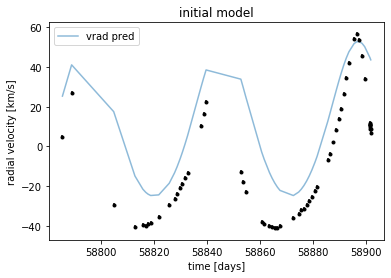

In [8]:
plt.errorbar(x, y, yerr=yerr, fmt=".k")

with model:
    plt.plot(x, xo.eval_in_model(rv_model), alpha=0.5, label='vrad pred')
#     plt.plot(t, xo.eval_in_model(vrad_pred), alpha=0.5, label='vrad pred')
plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [km/s]")
plt.title("initial model");

In [9]:
with model:
    map_soln = xo.optimize(start=model.test_point)
    map_soln = xo.optimize(start=map_soln)

optimizing logp for variables: [gammav, logs, omega, ecc, logK, P, t0]
225it [00:05, 40.44it/s, logp=-4.675203e+01] 
message: Desired error not necessarily achieved due to precision loss.
logp: -8568.221631572147 -> -46.75202797809975
optimizing logp for variables: [gammav, logs, omega, ecc, logK, P, t0]
145it [00:00, 228.82it/s, logp=-4.675203e+01]
message: Desired error not necessarily achieved due to precision loss.
logp: -46.75202797809975 -> -46.75202797808106


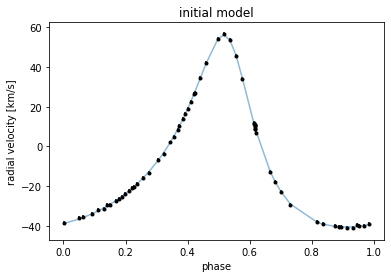

In [10]:
plt.errorbar(x % map_soln['P'] / map_soln['P'], y, yerr=yerr, fmt=".k")

with model:
    x_sort = x % map_soln['P'] / map_soln['P']
    sort = np.argsort(x_sort)
    plt.plot(x_sort[sort], xo.eval_in_model(rv_model, map_soln)[sort], alpha=0.5)
plt.xlabel("phase")
plt.ylabel("radial velocity [km/s]")
plt.title("initial model");

In [11]:
np.random.seed(42)
with model:
    trace = pm.sample(tune=2000, draws=2000, step=xo.get_dense_nuts_step(target_accept=0.95, start=map_soln))

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [gammav, logs, omega, ecc, logK, P, t0]
Sampling 2 chains, 0 divergences: 100%|██████████| 8000/8000 [01:47<00:00, 74.52draws/s] 


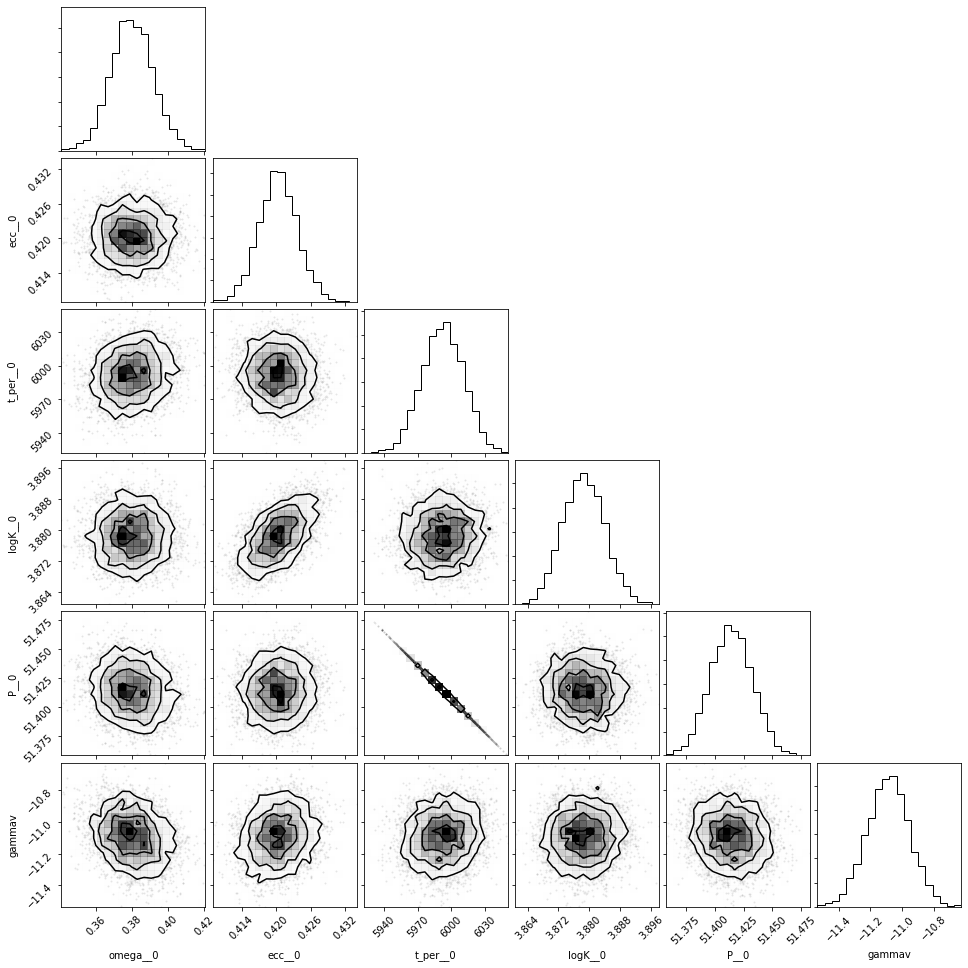

In [12]:
import corner

corner.corner(pm.trace_to_dataframe(trace, varnames=["omega", "ecc", "t_per", "logK", "P", 'gammav']));

In [48]:
# pm.save_trace(trace, 'data/traces/rv_fit')

In [49]:
%run setup.py

(0, 1)

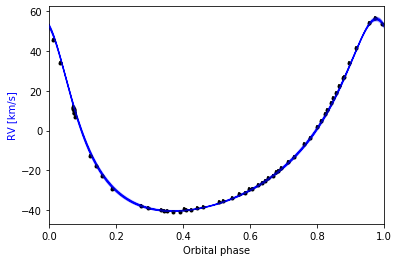

In [13]:
plt.figure()
gv = np.mean(trace['gammav'])
with model:
    for sample in xo.get_samples_from_trace(trace, 500):
        
        tt = (t - sample['t_per']) % sample['P'] / sample['P']
        sort = np.argsort(tt)
        plt.plot(tt[sort], sample['vrad_pred'][sort] + gv, alpha=0.1, label='vrad pred', linewidth=0.1, c='blue', zorder=5)
        
plt.errorbar((x - np.median(trace['t_per'])) % np.mean(trace['P']) / np.mean(trace['P']), y, yerr=yerr, fmt=".k", zorder=1)

plt.xlabel('Orbital phase')
plt.ylabel('RV [km/s]', c='blue')
plt.xlim(0,1)

# plt.savefig('figs/rv_fit.png', dpi=300, bbox_inches='tight', pad_inches=0)

In [14]:
import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 9
mpl.rcParams['ytick.labelsize'] = 9
mpl.rcParams['axes.labelsize'] = 9
mpl.rcParams['figure.figsize'] = (12.0, 4.0)

import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import cm
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

from matplotlib import rcParams

rcParams["figure.dpi"] = 150
rcParams["savefig.dpi"] = 300

orbital_period = 51.4167

In [16]:
%run setup.py

In [93]:
x, y, yerr = np.loadtxt('../soda_rv2.txt',usecols=(0,1,2)).T

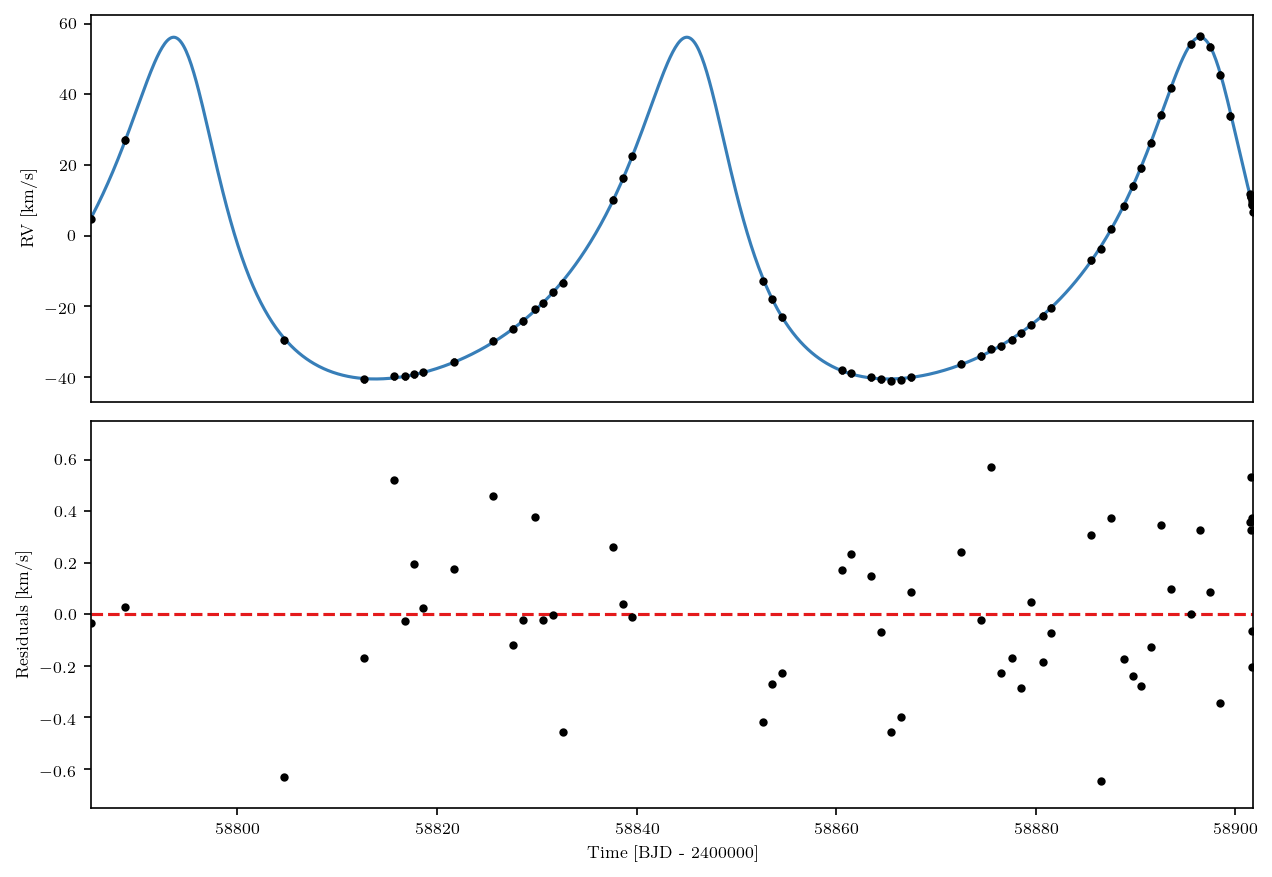

In [17]:
fig, axes = plt.subplots(2,1, figsize=[10,7]
#                          gridspec_kw={'height_ratios': [1.,0.4]}
                        )

ax = axes[0]
ax.plot(t, np.median(trace['vrad_pred'], axis=0) + np.median(trace['gammav']), c=blue)
ax.errorbar(x, y, yerr=yerr, fmt=".k", zorder=50)
ax.set_ylabel('RV [km/s]')
ax.set_xlim(x[0], x[-1])
ax.set_xticks([])
ax = axes[1]
ax.plot(x,y-np.median(trace['rv_model'], axis=0),'.k', zorder=50)
ax.axhline(0., c=red, linestyle='dashed')

ax.set_xlabel('Time [BJD - 2400000]')
ax.set_ylabel('Residuals [km/s]')
ax.set_ylim(-0.75, 0.75)
ax.set_xlim(x[0], x[-1])
plt.subplots_adjust(hspace=0.05)

# plt.savefig('rv_fit.png', dpi=300, bbox_inches='tight')

FileNotFoundError: [Errno 2] No such file or directory: '/Users/danielhey/Dropbox (Sydney Uni)/Apps/Overleaf/alpha Dra AAS/figs/rv_fit.pdf'

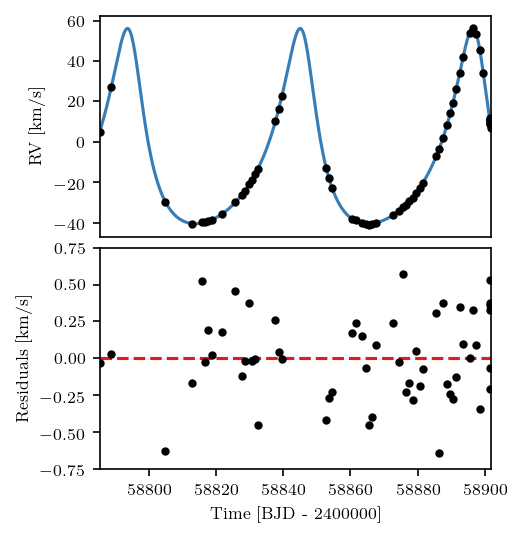

In [19]:
fig, axes = plt.subplots(2,1, figsize=[3.3648124999999998, 4.], 
#                          gridspec_kw={'height_ratios': [1.,0.4]}
                        )

ax = axes[0]
ax.plot(t, np.median(trace['vrad_pred'], axis=0) + np.median(trace['gammav']), c=blue)
ax.errorbar(x, y, yerr=yerr, fmt=".k", zorder=50)
ax.set_ylabel('RV [km/s]')
ax.set_xlim(x[0], x[-1])
ax.set_xticks([])
ax = axes[1]
ax.plot(x,y-np.median(trace['rv_model'], axis=0),'.k', zorder=50)
ax.axhline(0., c=red, linestyle='dashed')

ax.set_xlabel('Time [BJD - 2400000]')
ax.set_ylabel('Residuals [km/s]')
ax.set_ylim(-0.75, 0.75)
ax.set_xlim(x[0], x[-1])
plt.subplots_adjust(hspace=0.05)

plt.savefig(overleaf_path + 'rv_fit.pdf', dpi=300, bbox_inches='tight', pad_inches=0.)

In [70]:
import lightkurve as lk

lk.search_lightcurvefile('alpha Draconis', mission='TESS')

#,observation,target_name,productFilename,distance
0,TESS Sector 14,165991532,tess2019198215352-s0014-0000000165991532-0150-s_lc.fits,0.0
1,TESS Sector 15,165991532,tess2019226182529-s0015-0000000165991532-0151-s_lc.fits,0.0
2,TESS Sector 16,165991532,tess2019253231442-s0016-0000000165991532-0152-s_lc.fits,0.0


In [69]:
pm.summary(trace, varnames=["logs", "omega", "ecc", "t0", "logK", "P", 'gammav'])

/Users/danielhey/anaconda3/lib/python3.7/site-packages/pymc3/stats/__init__.py:21: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.9
  "pymc3 3.9".format(old=old, new=new)


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
logs,-5.075,2.678,-10.029,-1.116,0.055,0.042,2356.0,2076.0,2946.0,2454.0,1.0
omega[0],0.382,0.016,0.353,0.413,0.000,0.000,3970.0,3970.0,3964.0,2700.0,1.0
ecc[0],0.422,0.004,0.414,0.430,0.000,0.000,4825.0,4825.0,4829.0,3042.0,1.0
t0,5995.673,18.763,5960.715,6030.536,0.273,0.193,4739.0,4736.0,4742.0,2803.0,1.0
logK[0],3.880,0.009,3.864,3.897,0.000,0.000,4380.0,4380.0,4399.0,2942.0,1.0
P[0],51.415,0.018,51.381,51.449,0.000,0.000,4741.0,4741.0,4741.0,2824.0,1.0
gammav,12.001,0.209,11.601,12.388,0.003,0.002,4398.0,4395.0,4397.0,2845.0,1.0


In [34]:
samples = pm.trace_to_dataframe(trace)

In [41]:
import astropy.units as u
import astropy.constants as c

mf = (samples['P__0'].values * u.day).to(u.s) * ((np.exp(samples['logK__0'].values) * u.km / u.s).to(u.m/u.s))**3 * (1 - (samples['ecc__0'].values)**2)**(3/2) / (2 * np.pi * c.G)
mf = mf.to(u.Msun)

In [42]:
np.mean(mf), np.std(mf)

(<Quantity 0.42030401 solMass>, <Quantity 0.00585052 solMass>)

In [50]:
np.sin(np.radians(5))

0.08715574274765817

In [53]:
(0.422 / 0.997) / 2.02

0.2095395096179628

In [11]:
np.radians(86.17310)

1.5040043216503256

In [12]:
import numpy as np
import astropy.units as u

(np.exp(3.861042) * (u.km / u.s) * (51.472162 * u.day).to(u.s) * np.sqrt(1-0.426692**2) / 
     (2 * np.pi)).to(u.R_sun)# / (299792.458 * u.km / u.s)

<Quantity 43.71924266 solRad>

In [4]:
import numpy as np
43.719 / np.sin(np.radians(87))

43.77899759468311

In [21]:
np.sin(np.radians(87))

0.9986295347545738

In [22]:
V = 3.68
BC = 0.8
M_bol = 4.75
(10 * (1/82.0863) * 2.1940616334193774)**(-1/2) * 10**(-0.1 * (V + BC - M_bol)) * 5778

11892.919141107921